Simple Linear Regression using Neural Network.

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
torch.__version__

'2.2.1+cu121'

# 1.Creating Dataset

In [ ]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start,end,step).unsqueeze(dim=1)
Y = bias + weight*X

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

In [ ]:
X_train.shape,X_test.shape

(torch.Size([40, 1]), torch.Size([10, 1]))

# 2.Go through Data

In [ ]:
def plot_data(train_data=X_train,train_labels=Y_train,
              test_data=X_test,test_labels=Y_test,
              predictions=None):
  """
  Plot training, testing and prediction values
  """
  plt.scatter(train_data,train_labels,c="b",s=4,label="Training data")
  plt.scatter(test_data,test_labels,c="g",s=4,label="Testing data")
  if predictions is not None:
    plt.scatter(test_data,predictions,c="r",s=4,label="Prediction data")

  plt.legend()

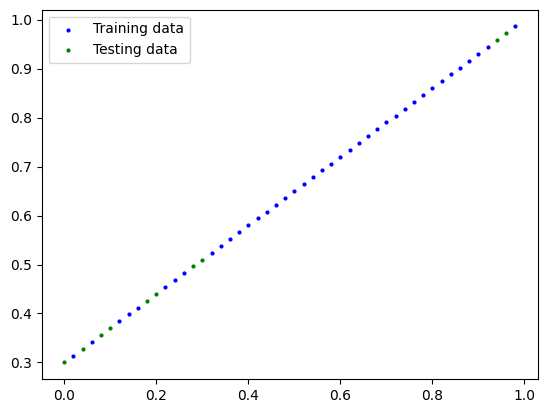

In [ ]:
plot_data()

# 3.Building a Regression Model

In [ ]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(
        1, requires_grad=True, dtype= torch.float))
    self.bias = nn.Parameter(torch.randn(
        1, requires_grad=True, dtype= torch.float))

  def forward(self,x:torch.Tensor) -> torch.Tensor:
      return self.weights*x+ self.bias

In [ ]:
# setting random seed
torch.manual_seed(42)

lr = LinearRegressionModel()
list(lr.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
lr.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
# Going into inference mode
with torch.inference_mode():
  y_preds = lr(X_test)

y_preds

tensor([[0.4520],
        [0.2298],
        [0.1423],
        [0.1625],
        [0.4453],
        [0.2231],
        [0.1894],
        [0.1961],
        [0.1288],
        [0.1557]])

In [ ]:
lr.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

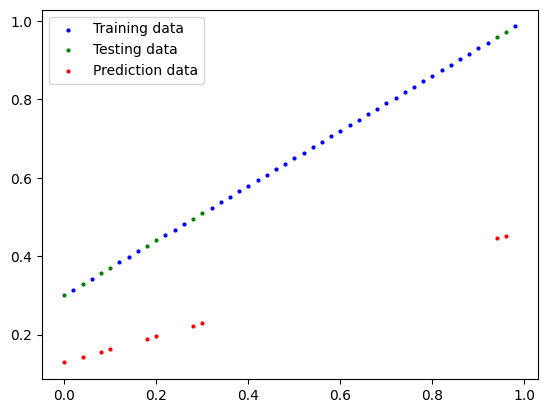

In [ ]:
plot_data(predictions=y_preds)

In [ ]:
loss_fn = nn.L1Loss()

In [ ]:
optim_fn = torch.optim.SGD(params=lr.parameters(),
                           lr=0.01)

In [ ]:
epochs = 75

for epoch in range(epochs):
  lr.train()

  # 1. forward pass
  y_pred = lr(X_train)

  # 2. calculate the loss
  loss = loss_fn(Y_train,y_pred)

  # 3. optimizer zero grad
  optim_fn.zero_grad()

  # 4. Loss backward
  loss.backward()

  # optimizer step
  optim_fn.step()



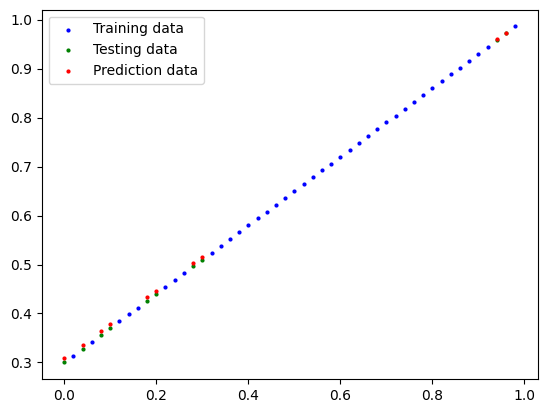

In [ ]:
with torch.inference_mode():
  pred = lr(X_test)
plot_data(predictions=pred)

In [ ]:
torch.save(obj=lr.state_dict(),f="/content/sample_data/simple_linear_regression_model.pth")

In [ ]:
loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(f="/content/sample_data/simple_linear_regression_model.pth"))

<All keys matched successfully>

In [ ]:
list(loaded_model.parameters())

[Parameter containing:
 tensor([0.6929], requires_grad=True),
 Parameter containing:
 tensor([0.3083], requires_grad=True)]

# 4.Putting all together including device agonostic code

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## 4.1 Creating Dataset

In [ ]:
# creating dataset
weight = 0.8
bias = 0.35
start = 0
end = 1
step =0.01

X = torch.arange(start,end,step).unsqueeze(dim=1)
Y = weight*X+bias

In [ ]:
X.device,Y.device

(device(type='cpu'), device(type='cpu'))

## 4.2 Building model

In [ ]:
class LinearReegressionModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(
                                1, requires_grad=True, dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(
                                1, requires_grad=True, dtype=torch.float))

  def forward(self,x: torch.Tensor) -> torch.Tensor:
    return self.weight*x+self.bias

In [ ]:
model_v1 = LinearReegressionModelV1()

## 4.3 Setup loss function and optimizer

In [ ]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_v1.parameters(),lr=0.01)

## 4.4 Train & Test split and add data & model to the same device

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

In [ ]:
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)



In [ ]:
list(model_v1.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

## 4.5 Train Test loop

In [ ]:
torch.manual_seed(42)
epochs = 201

for epoch in range(epochs):
  # move model to training mode
  model_v1.train()

  # forward pass
  pred_train = model_v1(X_train)

  # calculate the loss
  loss_train = loss_fn(pred_train,Y_train)

  # optimizer zero grad
  optimizer.zero_grad()

  # loss backward
  loss_train.backward()

  # optimizer step
  optimizer.step()

  model_v1.eval()
  with torch.inference_mode():
    pred_test = model_v1(X_test)
    loss_test = loss_fn(pred_test,Y_test)

  if epoch%10 == 0:
    print(f"epoch:{epoch} train_loss:{loss_train} pred_loss:{loss_test}")


epoch:0 train_loss:0.455683171749115 pred_loss:0.4176315367221832
epoch:10 train_loss:0.3300669491291046 pred_loss:0.2948305606842041
epoch:20 train_loss:0.2044508010149002 pred_loss:0.17202971875667572
epoch:30 train_loss:0.11046917736530304 pred_loss:0.08025339990854263
epoch:40 train_loss:0.0739930272102356 pred_loss:0.05570891499519348
epoch:50 train_loss:0.06147565692663193 pred_loss:0.050438474863767624
epoch:60 train_loss:0.05518297106027603 pred_loss:0.047455303370952606
epoch:70 train_loss:0.0498160645365715 pred_loss:0.04427094757556915
epoch:80 train_loss:0.04460061714053154 pred_loss:0.040607865899801254
epoch:90 train_loss:0.039462074637413025 pred_loss:0.035883091390132904
epoch:100 train_loss:0.034326571971178055 pred_loss:0.03115830384194851
epoch:110 train_loss:0.029191071167588234 pred_loss:0.026433521881699562
epoch:120 train_loss:0.024055570363998413 pred_loss:0.021708745509386063
epoch:130 train_loss:0.01892007328569889 pred_loss:0.016983959823846817
epoch:140 trai

In [ ]:
list(model_v1.parameters())

[Parameter containing:
 tensor([0.7929], requires_grad=True),
 Parameter containing:
 tensor([0.3476], requires_grad=True)]

In [ ]:
with torch.inference_mode():
  pred = model_v1(X_test)

## 4.6 Save & load the model


In [ ]:
torch.save(obj=model_v1.state_dict(),f="/content/drive/MyDrive/models/NeuralNetworkRegression_model_v1.pth")

In [ ]:
model_loaded = LinearReegressionModelV1()
model_loaded.load_state_dict(torch.load(f="/content/drive/MyDrive/models/NeuralNetworkRegression_model_v1.pth"))

<All keys matched successfully>

In [ ]:
list(model_loaded.parameters())

[Parameter containing:
 tensor([0.7929], requires_grad=True),
 Parameter containing:
 tensor([0.3476], requires_grad=True)]

In [ ]:
with torch.inference_mode():
  loaded_pred = model_loaded(X_test)

In [ ]:
pred == loaded_pred

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])